<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/german_credit_randomForest_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Refer [this file](https://github.com/harnalashok/classification/blob/main/pipelining_And_RandomForest/3_otto_rf.ipynb) for How RandomForest works

In [ ]:
# Last amended: 13th June, 2022
# Objectives:
#            i)  Using Random Forest
#           ii)  Feature importance and feature selection to improcve performance
#          iii)  Using Classification reports
#           iv)  Bin continuous variables as ordinal variables--Feature Engineering
#           v)   Using Category encoders
#           vi)  Create pipelines
#          vii)  Using ColumnTransformer
#         viii)  Using FunctionalTransformer
#           ix)  Using make_scorer()
#            x)  Using Repeated k-fold cross validation
#           xi)  Using GridSerachCV to tune parameters


In [ ]:
# PIPE's avoid data leakage
# During cross-validation, pipe develops a model on (K-1)-folds
#   and this model is applied on Kth held-out dataset. For example,
#    data scaling parameters are decided based on (K-1) folds and applied
#     on Kth fold. The knowledge of Kth fold is not leaked to scaler while
#      scaling (K-1) folds


In [ ]:
# 1.0 Call libraries
%reset -f
import pandas as pd
import numpy as np

# 1,1 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# 1.2 Model Selection
from sklearn.model_selection import train_test_split
# For lack of data, not possible to have more than 2-folds.
#  Better repeat two-folds multiple times
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# 1.3 Ensemble modeler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
# 1.4 Pipeline
from sklearn.pipeline import Pipeline

# 1.5 Scoring functions
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report, accuracy_score

# 1.6 Graphics and miscelleneous
import seaborn as sns
import os, gc


In [ ]:
# 1.7 Display multiple command outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# 1.8 Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 2.0 Data path
path = "/gdrive/MyDrive/Colab_data_files/autofeat/"
os.chdir(path)
os.listdir()

['german_credit.csv.zip',
 'heart.csv',
 'af.csv',
 'Concrete_Data_Yeh.csv',
 'concrete_train.csv',
 'concrete_test.csv']

In [ ]:
# 2.0
# 2.1 Read and explore data
df = pd.read_csv("german_credit.csv.zip")

In [ ]:
# 1.8.1 Explore data
df.head()
df.shape
df['creditability'].value_counts()

,creditability,account_balance,previous_credit_payment_status,credit_duration_month,purpose_of_earlier_credit,credit_amount,installment_percent,current_emploment_length,sex_and_marital_status,guarantors,duration_at_current_address,most_valuable_available_asset,age,concurrent_credits,apartmenttype,howmanycreditsat_this_bank,occupation,dependents,telephone,foreign_worker
0,1,1,4,18,2,1049,4,2,2,1,4,2,21,3,1,1,3,1,1,1
1,1,1,4,9,0,2799,2,3,3,1,2,1,36,3,1,2,3,2,1,1
2,1,2,2,12,9,841,2,4,2,1,4,1,23,3,1,1,2,1,1,1
3,1,1,4,12,0,2122,3,3,3,1,2,1,39,3,1,2,2,2,1,2
4,1,1,4,12,0,2171,4,3,3,1,4,2,38,1,2,2,2,1,1,2


(1000, 20)

1    700
0    300
Name: creditability, dtype: int64

In [ ]:
# 2.0 Quick plots
sns.distplot(df.credit_duration_month)
sns.boxplot(df.credit_duration_month)
sns.boxplot(df.credit_amount)
sns.boxplot(df.age)
sns.catplot('creditability', 'credit_amount',   data = df, kind = 'box' )
sns.catplot('foreign_worker', 'credit_amount',   data = df, kind = 'box' )
sns.catplot('foreign_worker', 'credit_amount', hue = 'creditability',  data = df, kind = 'box' )
sns.catplot('creditability', 'credit_amount', col= 'purpose_of_earlier_credit', col_wrap = True, data = df, kind = 'box' )
sns.relplot('credit_amount', 'age', row = 'creditability', data = df)


In [ ]:
# 3.0 Separate into predictors (X) and target (y)
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [ ]:
# 3.1 Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify = y )

In [ ]:
##################################333
## Simple approach to modeling
####################################

In [ ]:
# 3.2 Create an instance of RandomForestClassifier
#     with suitable parameters
clf = RandomForestClassifier(n_estimators = 1000)

In [ ]:
# 3.3 Train model
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
# 3.4 Make predictios
y_pred = clf.predict(X_test)

In [ ]:
# 3.5 Classification report
print(classification_report(y_test, y_pred), accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50        60
           1       0.78      0.88      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200
 0.745


In [ ]:
# 3.6 This is what support means.
#     How many are 1's and how many are 0s
np.sum(y_test)

140

In [ ]:
# 4.0 Get feature importances
importances = clf.feature_importances_

In [ ]:
# 4.1 Rank features as per importances
#      (in order of Decreasing importance)
#     Get indicies of important features

indices = np.argsort(-importances)   # Note the negative sign
indices

#indices = np.argsort(importances)[::-1]
#indices


array([ 4,  0, 11,  2,  3,  1,  6,  5, 10,  9, 15,  7, 13, 12, 14, 17,  8,
       16, 18])

In [ ]:
# 4.2 Get names of important columns in order of importance
names = X_train.columns.values[indices]
names


array(['credit_amount', 'account_balance', 'age', 'credit_duration_month',
       'purpose_of_earlier_credit', 'previous_credit_payment_status',
       'current_emploment_length', 'installment_percent',
       'most_valuable_available_asset', 'duration_at_current_address',
       'occupation', 'sex_and_marital_status', 'apartmenttype',
       'concurrent_credits', 'howmanycreditsat_this_bank', 'telephone',
       'guarantors', 'dependents', 'foreign_worker'], dtype=object)

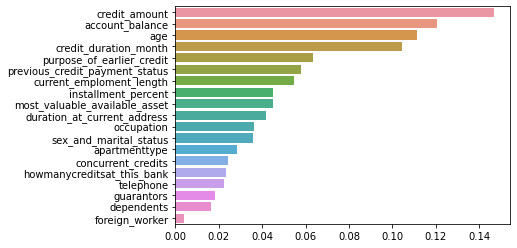

In [ ]:
# 4.3 Plot attribute importance chart
sns.barplot(y = names,x = importances[indices])


In [ ]:
# 5.0 Select only impt features
# 5.1
clf_sel = RandomForestClassifier(n_estimators = 1000)

In [ ]:
# 5.2
feat_sel = SelectFromModel(clf_sel,
                           threshold = '0.25*mean',      # Take 'mean' that is np.mean(clf.feature_importances_)
                                                         #   alternative is 'median'
                           prefit = False
                           )

In [ ]:
# 5.3 Now fit and learn feature importances
feat_sel.fit(X_train,y_train)
print("\n")
feat_sel.threshold_      # 0.05263157894736842


SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000),
                threshold='0.25*mean')

0.013157894736842105

In [ ]:
# 6.0 Get mask for important features:
feat_sel.get_support()

In [ ]:
# # 6.1 Get important features:
imp_features = X_train.columns[feat_sel.get_support()]
imp_features
print("\n No of imp features: ", len(imp_features))

Index(['account_balance', 'previous_credit_payment_status',
       'credit_duration_month', 'purpose_of_earlier_credit', 'credit_amount',
       'installment_percent', 'current_emploment_length',
       'sex_and_marital_status', 'guarantors', 'duration_at_current_address',
       'most_valuable_available_asset', 'age', 'concurrent_credits',
       'apartmenttype', 'howmanycreditsat_this_bank', 'occupation',
       'dependents', 'telephone'],
      dtype='object')


 No of imp features 18


In [ ]:
# 7.0 Use only the important columns for fresh model
clfs = RandomForestClassifier(n_estimators=1000)
clfs.fit(X_train[imp_features], y_train)
ys_pred = clfs.predict(X_test[imp_features])

RandomForestClassifier(n_estimators=1000)

In [ ]:
# 7.1 F1 score gets improved
print(classification_report(y_test, ys_pred), accuracy_score(y_test, ys_pred))
# 7.2 This is what support means. How many are 1's and how many are 0s
np.sum(y_test)


              precision    recall  f1-score   support

           0       0.63      0.45      0.52        60
           1       0.79      0.89      0.84       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200
 0.755


140

In [ ]:
######################################################################33
# Part II Little Feature engineering
#######################################################################

In [ ]:
# 8.0 Experimental. Discretize 'age' and 'credit_amount' features
#     Check results
X_imp_feat_train = X_train[imp_features]
X_imp_feat_test = X_test[imp_features]
                              

In [ ]:
X_imp_feat_train.iloc[:, [4,5]].head()    # 4 and 5 are 'credit_amount' and 'age'. GOES ON CHANGING


,credit_amount,installment_percent
15,2647,2
603,1289,4
597,571,4
923,5293,2
724,4020,2


In [ ]:
# 8.1 Begin discretization
dis = KBinsDiscretizer(encode =  'ordinal',
                       strategy = 'kmeans',
                       n_bins = 5)


In [ ]:
# 8.2 Discretize into two new features
dis.fit(X_imp_feat_train.iloc[:,[4,5]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:219: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


KBinsDiscretizer(encode='ordinal', strategy='kmeans')

In [ ]:
# 8.3
X_train_feat_new = dis.transform(X_imp_feat_train.iloc[:, [4,5]])
X_test_feat_new = dis.transform(X_imp_feat_test.iloc[:, [4,5]])
X_train_feat_new

array([[1., 1.],
       [0., 3.],
       [0., 3.],
       ...,
       [1., 3.],
       [0., 1.],
       [0., 3.]])

In [ ]:
# 8.4 Horizontal stack with existing features
X_imp_feat_train = np.hstack([X_imp_feat_train,X_train_feat_new ])
X_imp_feat_test = np.hstack([X_imp_feat_test, X_test_feat_new])

In [ ]:
# 8.5 Check
X_imp_feat_train.shape           # (800, 20)
X_imp_feat_test.shape            # (200, 20)

(800, 20)

(200, 20)

In [ ]:
# 9.0 Model and get classification report
clfn = RandomForestClassifier(n_estimators=1000)
clfn.fit(X_imp_feat_train, y_train)
yn_pred = clfn.predict(X_imp_feat_test)

RandomForestClassifier(n_estimators=1000)

In [ ]:
# 9.1 Get allreports at one place
print(classification_report(y_test, y_pred), accuracy_score(y_test,y_pred))
print(classification_report(y_test, ys_pred), accuracy_score(y_test, ys_pred))
print(classification_report(y_test, yn_pred), accuracy_score(y_test, yn_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50        60
           1       0.78      0.88      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200
 0.745
              precision    recall  f1-score   support

           0       0.63      0.45      0.52        60
           1       0.79      0.89      0.84       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200
 0.755
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        60
           1       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200
 0.755


In [ ]:
#################################
# Part III: Feature engineering as a part of pipe
#################################


In [ ]:
# 10 Putting all together i
#     Generally gives realistic results
#      Transform data => Select K Best => Preform modeling

# 10.1 Columns that we will discretise
num_cols = ['credit_amount', 'age']

# 10.2 Get locations of columns in our dataset
v1 = np.where(X_train.columns.values == 'age')             # returns location as an array
v2 = np.where(X_train.columns.values == 'credit_amount')
v1        # v1 is array:  (array([11], dtype=int64),)
v1,v2= np.asscalar(v1[0]), np.asscalar(v2[0])     # Array to scalar
v1,v2

# 10.3 Instaniate discretizer
dis = KBinsDiscretizer(encode =  'ordinal',
                       strategy = 'kmeans',
                       n_bins = 3)

# 10.4 As a demo of its use, fit it ans use it to transform data
dis.fit(X_train)
dis.transform(X_train)[ : ,[v1,v2] ]

# 10.5 After transformation of a column by KBinsDiscretizer,
#       that column is dropped. To continue to keep that column,
#        let us create a duplicate
#         We can also create a function to automatically create
#          duplicates of whichever columns we are discretizing

# 10.6 Write a function to discretise

def my_duplicator(x):
    for i in x:
        newColname = i + "_dup"
        X_train[newColname] = X_train[i]
        X_test[newColname] = X_test[i]

my_duplicator(num_cols)

# 10.6.1 Check
X_train.head()
X_test.head()


# 11. We now use ColumnTransformer
# Syntax: ColumnTransformer(transformers, remainder='drop' or 'passthrough')
#                           transformers =  (name, transformer, columns)
ct = ColumnTransformer(
                        [
                         ('ct', dis, num_cols)           # This list contains only one transformer tuple
                        ],
                        remainder = 'passthrough'
                      )

# 11.1 Our estimator/classifier will be the RF object
#      Instaniate the RandomForestClassifier class
estimator = RandomForestClassifier(n_estimators = 1000)

# 11.2 Create a pipline of all operations. In ColumnTransformer, operations on Columns
#      take place parallely, in pipeline, these are sequential
pipe = Pipeline([
                 ('colTrans', ct),                                                        # Transform columns
                 ('sb', SelectFromModel(estimator, threshold = 'mean', prefit = False)),  # Select best possible features
                 ('rf', RandomForestClassifier(n_estimators = 1000))                      # Use best features for modeling
                 ]
                )

# 11.3 Train the pipe and make predictions
pipe.fit(X_train, y_train)
yd_pred = pipe.predict(X_test)

# 11.4 All results at one place.. Compare accuracy score also
print(classification_report(y_test, y_pred), accuracy_score(y_test,y_pred))
print(classification_report(y_test, ys_pred), accuracy_score(y_test, ys_pred))
print(classification_report(y_test, yn_pred), accuracy_score(y_test, yn_pred))
print(classification_report(y_test, yd_pred), accuracy_score(y_test, yd_pred))


(array([11]),)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if sys.path[0] == '':


(11, 4)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:219: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 16 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:219: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 17 are removed. Consider decreasing the number of bi

KBinsDiscretizer(encode='ordinal', n_bins=3, strategy='kmeans')

array([[1., 0.],
       [0., 0.],
       [2., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

,account_balance,previous_credit_payment_status,credit_duration_month,purpose_of_earlier_credit,credit_amount,installment_percent,current_emploment_length,sex_and_marital_status,guarantors,duration_at_current_address,...,age,concurrent_credits,apartmenttype,howmanycreditsat_this_bank,occupation,dependents,telephone,foreign_worker,credit_amount_dup,age_dup
15,1,2,6,3,2647,2,3,3,1,3,...,44,3,1,1,3,2,1,1,2647,44
603,1,2,12,2,1289,4,3,3,3,1,...,21,3,2,1,2,1,1,1,1289,21
597,1,4,21,0,571,4,5,3,1,4,...,65,3,2,2,3,1,1,1,571,65
923,1,0,27,9,5293,2,1,3,1,4,...,50,3,2,2,3,1,2,1,5293,50
724,1,2,24,2,4020,2,3,3,1,2,...,27,2,2,1,3,1,1,1,4020,27


,account_balance,previous_credit_payment_status,credit_duration_month,purpose_of_earlier_credit,credit_amount,installment_percent,current_emploment_length,sex_and_marital_status,guarantors,duration_at_current_address,...,age,concurrent_credits,apartmenttype,howmanycreditsat_this_bank,occupation,dependents,telephone,foreign_worker,credit_amount_dup,age_dup
535,2,2,24,3,1967,4,5,2,1,4,...,20,3,2,1,3,1,2,1,1967,20
524,2,4,12,1,1860,4,1,3,1,2,...,34,3,2,2,4,1,2,1,1860,34
848,2,2,36,3,2671,4,3,2,2,4,...,50,3,3,1,3,1,1,1,2671,50
995,1,2,24,3,1987,2,3,3,1,4,...,21,3,1,1,2,2,1,1,1987,21
0,1,4,18,2,1049,4,2,2,1,4,...,21,3,1,1,3,1,1,1,1049,21


Pipeline(steps=[('colTrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='kmeans'),
                                                  ['credit_amount', 'age'])])),
                ('sb',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000),
                                 threshold='mean')),
                ('rf', RandomForestClassifier(n_estimators=1000))])

              precision    recall  f1-score   support

           0       0.60      0.43      0.50        60
           1       0.78      0.88      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200
 0.745
              precision    recall  f1-score   support

           0       0.63      0.45      0.52        60
           1       0.79      0.89      0.84       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200
 0.755
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        60
           1       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200
 0.755
 

In [ ]:
#############################################################
## Part IV: Using GridSearchCV or cross-validation while fitting pipe
#############################################################


In [ ]:
# 12.0 Columns to discretize
num_cols = ['credit_amount', 'age']
# 12.1 Our discretizer
dis = KBinsDiscretizer(encode =  'ordinal',
                       strategy = 'kmeans',
                       n_bins = 3)
# 12.2 Our estimator for selecting best columns
#      in SelectFromModel
estimator = RandomForestClassifier(n_estimators = 1000)
# 12.3 ColumnTransformer
ct = ColumnTransformer(
                        [
                        ('ct', dis, num_cols)             # One transformer
                        ],
                        remainder = 'passthrough'       # Allow all other columns
                        )


# 12.4 This is a demo of use of FunctionTransformer
#        Define a function to scale
#          just two columns. These will
#            be last two columns: age_dup and credit_amount_dup
def my_transform(X):
    ss = StandardScaler()
    X[:, [-1,-2]] = ss.fit_transform(X[:, [-1,-2]])
    return X

# 12.5 Our function will be part of pipeline. It must have fit()
#       and tranform() methods. We wrap it in FunctionTransformer()
#        Instantiate the transormer object using our function
#         as a parameter
scaler = FunctionTransformer(my_transform,           # Our function as a parameter
                             validate = False        # Do not check if array is 2D
                             )

# 12.5 Check if this scaler works
#      Create some array of shape (4 X 4)
db = np.array( [
                [3,2,4,1],
                [1,2,3,4],
                [2,3,1,2],
                [1,2,2,3],
               ]
             )

db
# 12.5.1 Use scaler object
scaler.fit(db)           # Train scaler
scaler.transform(db)     # Transform data

# 13. Create new features from few categorical variables
#      This is again a demo. We will encode these features
#      using WOEEncoder of category_encoders
encoder = ce.WOEEncoder(cols=['account_balance', 'previous_credit_payment_status', 'current_emploment_length', 'sex_and_marital_status'])
# 13.1 Let us fit it
encoder.fit(X_train,y_train)
# 13.2 Test if this encoder works
out = encoder.transform(X_train)
out

# 14. Finally put all the above in a pipeline in the order it will be carried out
pipe = Pipeline([
                 #('woe', encoder),                               # May commentout if performance is bad
                 ('colTrans', ct),                                # Bin  ['credit_amount', 'age'] using kmeans
                 #('myScaler', scaler),                           # Scale 'age_dup' and 'credit_amount_dup'
                 ('sb', SelectFromModel(estimator,                # Select the best features
                                        threshold = 'mean',       # 'median' is another option
                                        prefit = False
                                        )
                ),

                 ('rf', RandomForestClassifier(n_estimators = 1000))  # Fit
                ]
                )


# 14.1 We now require to write a parameter grid.
#      While in a simple object, parameter-names
#      are straight-forward, ia nested object
#      or a pipeline, objects have prefixes added
#      to their parameters.
#      Get list of complete parameters.
#      to know parameter names
pipe.get_params()

# 14.2 Out of above, we will consider these parameters for tuning:
"""
colTrans__ct__n_bins : 3,
colTrans__ct__strategy : 'kmeans'
sb__threshold': 'mean'
rf__criterion': 'gini'
rf__min_samples_leaf': 1,
sb__estimator__min_samples_leaf': 1
sb__estimator__criterion': 'gini',

# param-grid can be a list of dictionaries
#  Each dictionary can be a set of parameters
#   Each dictionary is used at a time.
param_grid = [
             {'rf__criterion : 'entropy', ....},
             {'rf__criterion' : 'gini', .....}


"""
# 14.3 We create three dictionaries depending upon our
#      strategy for KBinsDiscretizer. Though, we could
#       have put everything in one dictionary, but this
#        bifurcation brings clarity to our list
param_grid = [ {                                                # Panel 1
                 'colTrans__ct__strategy' : ['kmeans'],
                 'sb__threshold': ['mean', 'median'],
                 'rf__criterion' : ['entropy', 'gini'],
                 'rf__min_samples_leaf': [1, 2,3,4,5]
                 },

               {                                               # Panel 2
                 'colTrans__ct__strategy' : ['quantile'],
                 'sb__threshold': ['mean', 'median'],
                 'rf__criterion' : ['entropy', 'gini'],
                 'rf__min_samples_leaf': [1, 2,3,4,5]
                },

               {                                               # Panel 3
                 'colTrans__ct__strategy' : ['uniform'],
                 'sb__threshold': ['mean', 'median'],
                 'rf__criterion' : ['entropy', 'gini'],
                 'rf__min_samples_leaf': [1, 2,3,4,5]
                }
             ]


# 15. GridSearchCV takes a parameter set and makes predictions
#      It judges the prediction performance against scorer
#       specified  for the purpose (eg 'accuracy'). In our
#        case we want to maximise F1 score.
# By default, F1 score takes 1 as positive class.
#  In our case '0' is the +ve class. We will, therefore,
#   will have to define our own scorer function using
#    sklearn's 'make_scorer()'
# 15.1
# Step 1: Define your own scorer first
def myscorer(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label = 0)

# 15.2
# Step 2: Make your scorer as the scorer for sklearn's algorithms
#         For the purpose, we use make_scorer()
my_scorer = make_scorer(
                        myscorer,
                        greater_is_better = True
                        )

# 15.3
# Create an instance of Repeated Stratified K-Fold cross validator.
#  It returns the number of splitting iterations in the cross-validator.
#   Returned object is a sort of iterartor ie 'rpt.split(X,y)' returns
#    a generator to be used in GridSearchCV
rpt = RepeatedStratifiedKFold(
                              n_splits = 2,          # Number of folds
                              n_repeats = 3          # As we cannot have more than two folds
                                                     #  better repeat two-folds multiple times
                              )

# 15.4
# Create an instance of GridSearchCV. We name the object as 'grid'
grid = GridSearchCV(pipe,
                    param_grid = param_grid,                # What is our parameter grid
                    scoring = my_scorer,                    # my_scorer,
                    verbose =1,                             # Since it is a long process, show some progress
                    cv = rpt,                               # We can also use here a scalar value
                                                            # Values can be: int, cross-validation generator or an iterable, optional
                    n_jobs = 3                              # Three parallel jobs
                    )

# 15.5
# Train 'grid' object now. After training, model
#  is returned with the best set of parameters.
%timeit grid.fit(X_train,y_train)

# 15.6 Use 'grid' object to make predictions on Test data
yg_pred = grid.predict(X_test)

# 15.7 Publish all Classification reports now.
print(classification_report(y_test, y_pred), accuracy_score(y_test,y_pred))
print(classification_report(y_test, ys_pred), accuracy_score(y_test, ys_pred))
print(classification_report(y_test, yn_pred), accuracy_score(y_test, yn_pred))
print(classification_report(y_test, yd_pred), accuracy_score(y_test, yd_pred))
print(classification_report(y_test, yg_pred), accuracy_score(y_test, yg_pred))


# 16.0 DEBUGGING PIPELINE, if there is a problem
#      Look again at possible list of parameters
pipe.get_params()
# 16.1 Look at the predictions made
yg_pred

# 16.2 Our test data and our predicted data
sum(y_test)
len(y_test)
sum(yg_pred)

# 16.3 Check 1. Does pipe fit on its own (no grid search)?
pipe.fit(X_train,y_train)
yf_pred = pipe.predict(X_test)
print(classification_report(y_test, yf_pred), accuracy_score(y_test, yf_pred))
# 16.4 Check 2: Does column transformer work?
ct.fit(X_train,y_train)
ct.transform(X_train)
######################
######################
